# Homework 3 

You will have 2 datasets to work on. 
#### You have to answer questions in this [form](https://goo.gl/forms/5gfxvKZxpoydoeOB2) and provide your code

### 1. Wikipedia Web Traffic Time Series

Data from [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting)* )

*wikipedia_train3* - train data *wikipedia_test3* - test data created by us from original train data . For more information about dataset, please visit Homework1 assignment


### 2. French dataset

Target variable is prime_tot_ttc – house of insurance price.<p>
The variables in the files are:<p>
code_postal: postal code of the insured property<p>
nb_pieces: number of rooms<p>
veranda: presence of a veranda<p>
biens_nomades: ceiling of coverage of goods (laptop, tablets, musical instruments ,…)<p>
sit_fam: family situation of the insured<p>
profession: profession of the insured<p>
nature_lri: nature of the insured property<p>
societe: company covering the risk<p>
cdomact: area of activity of the insured<p>
niv_urbanisation: level of urbanization in which is the insured property<p>
age_societaire: age of the member<p>
objets_precieux: presence of precious objects in the insured property<p>
pres_contrat_auto: holding a contract of auto insurance<p>
formule: guarantee formula<p>
sit_juridique: legal situation<p>
surf_habitat: area of insured property<p>
patrimoine_mob: amount of heritage insured furniture<p>
var1 - ... - var11: non-explicit variables<p>


In [1]:
import pandas as pd
import numpy as np
#for EDA
import pandas_profiling as pp


from dateutil.relativedelta import relativedelta
import math
from math import fabs

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder

# vizualizing
import matplotlib.pyplot as plt
% matplotlib inline 
import seaborn as sns
import matplotlib.style as style
import calmap 
import warnings
warnings.simplefilter('ignore')

## French house insurance prediction (MAPE metric)

**1.** Take a look carefuly at train and test dataset. Note for you what is the difference in them and how they are dependent. You may use any tool you like, any EDA you want. Decribe your validation and reason for your choice in google form.

**2.** 
+ Implement your validation. 
+ Generate additional features. 
+ Build a model you like/you can. 
+ Wait for training your model. If it takes too much time, listen to https://www.youtube.com/watch?v=XWkGL4eZR3E
+ Submit your scores on validation and test to google form. Use MAPE metric for scoring. 
+ Ланфрен ланфра лантатита

In [2]:
train = pd.read_csv('../data/train_french.csv')
test = pd.read_csv('../data/test_french.csv')

In [60]:
train.head(2)

,code_postal,nb_pieces,veranda,biens_nomades,sit_fam,profession,nature_lri,societe,domaine_activite,niv_urbanisation,...,var3,var4,var5,var6,var7,var8,var9,var10,var11,prime_tot_ttc
0,62510,1,NON,500,Indivividu,agent; employe,Sans information,2,34,A,...,0,194,49,0,0,1,NON,30,2,67.68
1,83126,2,NON,500,Indivividu,cadre; ingenieur,Sans information,2,37,A,...,0,0,100,0,0,5,NON,12,1,120.60


In [61]:
pp.ProfileReport(train)

Number of variables,29
Number of observations,200000
Total Missing (%),0.0%
Total size in memory,44.3 MiB
Average record size in memory,232.0 B
Numeric,15
Categorical,6
Boolean,8
Date,0
Text (Unique),0
Rejected,0


In [3]:
test.nb_pieces.value_counts(normalize=True)

4    0.207061
3    0.205192
2    0.171993
1    0.171533
6    0.131634
5    0.112587
Name: nb_pieces, dtype: float64

In [9]:
train = pd.read_csv('../data/train_french.csv')
test = pd.read_csv('../data/test_french.csv')

categorical_features = ['veranda', 'profession', 'sit_fam', 'nature_lri', 'niv_urbanisation', 'var9' ]#features to encode 

def prepare_data(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()
    enc = LabelEncoder()
    all_data = pd.concat([train, test], axis=0)
    for feature in categorical_features:
        enc.fit(all_data[feature])
        train[feature] = enc.transform(train[feature])
        test[feature] = enc.transform(test[feature])
    train['niv_urbanisation'] = train_df['niv_urbanisation'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5,'F':6, 'G':7, '~':0})
    test['niv_urbanisation'] = test_df['niv_urbanisation'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5,'F':6, 'G':7, '~':0})    
    xtrain = train.drop(['prime_tot_ttc'], axis=1)
    xtest = test.drop(['prime_tot_ttc'], axis=1)
    ytrain = train['prime_tot_ttc']
    ytest = test['prime_tot_ttc']
    return xtrain, xtest, ytrain , ytest
    
def mape(y_true, y_pred):
    return np.sum(100. / y_true.shape[0] * np.abs((y_true - y_pred) / y_true))


xtrain, xtest, ytrain , ytest = prepare_data(train, test)
    

In [4]:
train.nb_pieces.value_counts(normalize=True)

4    0.242100
3    0.239345
1    0.195760
2    0.194170
5    0.128625
Name: nb_pieces, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

flat_5_indices = train.index[train.nb_pieces == 5 ].values
flat_no_5_indices = train.index[train.nb_pieces != 5 ].values

validation_5 = split_list(flat_5_indices, 5)
valid_size = round (len(validation_5[0]) / ( 1 - 0.13) )# with flats!= 5 
train_size = len(train) * ( len(train[train.nb_pieces==5])+ len(test)) / ( 5 * len(test))
total_size = valid_size + train_size 
percent  = valid_size / (valid_size + train_size)

train_percent = (train_size + valid_size )/ len (flat_no_5_indices )

MY_CV = []
for validation_with_no_5 in validation_5:
    train_m , rest  = train_test_split(train.loc[flat_no_5_indices], test_size=train_percent)
    train_s, add_to_valid = train_test_split(train_m, test_size=percent)
    train_indices = train_s.index
    validation_indices = np.append(validation_with_no_5, add_to_valid.index.values)
    MY_CV.append((train_indices, validation_indices))

In [7]:
def create_cross_val(X, len_holdout=30000, len_train=130000):
    cv = []
    for nb in range(1,6):
        len_nb = round(len(X[X.nb_pieces==nb]))
        len_nb_in_hold = round(0.13 * len_holdout)
        len_not_nb_in_hold = round(0.87 * len_holdout)
        with_nb = X.index[X.nb_pieces==nb]
        without_nb = X.index[X.nb_pieces != nb]
        valid = with_nb[:len_nb_in_hold]
        valid.append(without_nb[:len_not_nb_in_hold])
        train = without_nb[len_not_nb_in_hold:len_not_nb_in_hold + len_train]
        cv.append((train, valid))
    return cv

cv = create_cross_val(train)

In [12]:
def mape_for_cross_val(estimator, x_test, y_true):
    y_pr = estimator.predict(x_test)
    return mape(y_true, y_pr)

In [14]:
cv = create_cross_val(train)

best_dt = DecisionTreeRegressor(random_state=42)
best_dt.fit(xtrain, ytrain)
test_mape = mape(ytest, best_dt.predict(xtest))

cv_mape = cross_val_score(estimator=best_dt, cv=cv, X=xtrain,
                         scoring=mape_for_cross_val, y=ytrain).mean()
cv_mape - test_mape 

1.8954471816318819

In [17]:
from sklearn.ensemble import RandomForestRegressor
cv = create_cross_val(train, 23800, 110000)

best_rf = RandomForestRegressor(random_state=42)
best_rf.fit(xtrain, ytrain)
test_mape = mape(ytest, best_rf.predict(xtest))

cv_mape = cross_val_score(estimator=best_rf, cv=cv, X=xtrain,
                         scoring=mape_for_cross_val, y=ytrain).mean()
cv_mape - test_mape 

1.5081448834004281

In [66]:
import matplotlib.style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(10, 5)

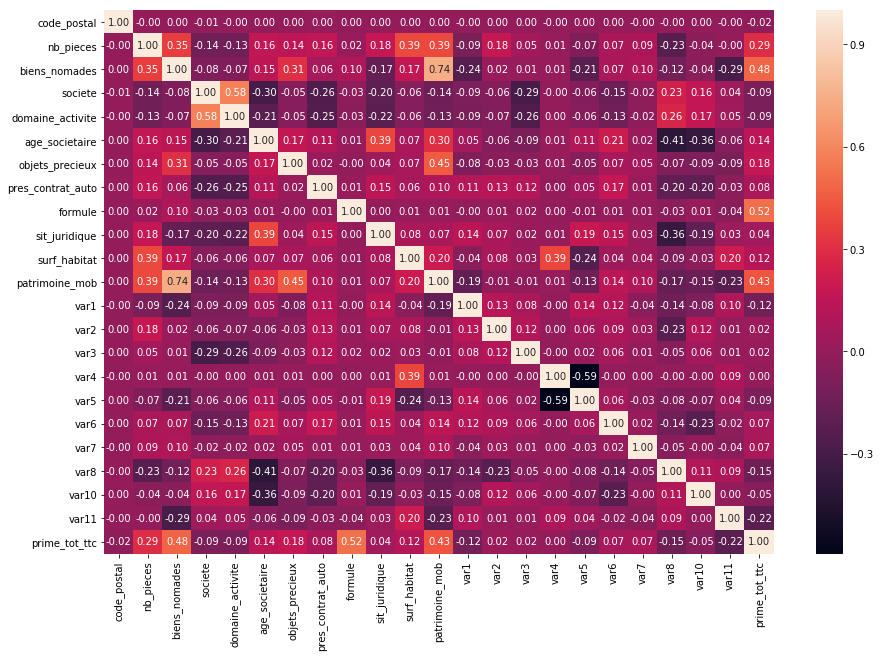

In [303]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(train.corr(), annot=True, fmt='.2f')

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( xtrain, ytrain, test_size=0.33, random_state=42)

est = DecisionTreeRegressor(random_state=42)

est.fit(X_train, y_train)
ypred = est.predict(X_test)
print( "mape for holdout  ", mape(y_test, ypred) )

est.fit(xtrain, ytrain)
ypred = est.predict(xtest)
print( "mape for test   ",  mape(ytest, ypred))

mape for holdout   11.776093435644944
mape for test    10.92419381774879


In [24]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=11, random_state=42)

scores = cross_val_score(cv=kf,
                         estimator=RandomForestRegressor(random_state=42),
                         n_jobs=-1,
                         X=X_train, y=y_train,
                         scoring=mape_for_cross_val, verbose=2).mean()

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  17.4s
[CV]  ................................................................
[CV] ................................................. , total=  17.6s
[CV] ................................................. , total=  17.8s
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  18.2s
[CV]  ................................................................
[CV] ................................................. , total=  20.5s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   55.8s finished


In [26]:
scores

10.769645709183491

In [28]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer

In [45]:
for feature in xtrain.columns:
    print(feature)
    x_train = xtrain.drop([feature], axis=1)
    x_test = xtest.drop([feature], axis=1)
    est = RandomForestRegressor(random_state=42)
    est.fit(x_train, ytrain)
    ypred =  est.predict(x_test)
    print('MAPE is ', mape(ytest, ypred))

code_postal
MAPE is  18.084335932345997
nb_pieces
MAPE is  9.918083518898756
veranda
MAPE is  9.884686126947583
biens_nomades
MAPE is  9.89934464399872
sit_fam
MAPE is  9.885961504723602
profession
MAPE is  9.810456818547106
nature_lri
MAPE is  9.865847216358814
societe
MAPE is  9.887057162316143
domaine_activite
MAPE is  9.827426180813127
niv_urbanisation
MAPE is  9.807120897238189
age_societaire
MAPE is  9.780510552557784
objets_precieux
MAPE is  9.873703634465924
pres_contrat_auto
MAPE is  9.868039594583763
formule
MAPE is  19.034741943149985
sit_juridique
MAPE is  10.672990104052428
surf_habitat
MAPE is  9.69820784250499
patrimoine_mob
MAPE is  11.456588911579166
var1
MAPE is  9.840521121232763
var2
MAPE is  9.855026913424034
var3
MAPE is  9.863400013019092
var5
MAPE is  9.814841443126198
var6
MAPE is  9.853334050417489
var7
MAPE is  9.870675242526541
var8
MAPE is  9.893701691882292
var9
MAPE is  9.867023675386212
var10
MAPE is  9.862727487699445
var11
MAPE is  9.845715586253327


In [32]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, learning_rate=0.6)
params = {'max_depth' : (10, 9),#8
         "n_estimators": (15,100)}
grid = GridSearchCV(estimator=xgb, param_grid=params, cv=cv, verbose=1,
                    scoring=make_scorer(mape, greater_is_better=False), n_jobs=4)
grid.fit(xtrain, ytrain)
best_ = grid.best_estimator_

best_.fit(xtrain, ytrain)
test_mape = mape(ytest, best_.predict(xtest))
cv_mape = cross_val_score(estimator=best_, cv=cv, X=xtrain,
                         scoring=mape_for_cross_val, y=ytrain).mean()

print(f"CV MAPE: {cv_mape}\nTest MAPE: {test_mape}\nDiff: {round(abs(cv_mape - test_mape),4)}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  2.5min finished


CV MAPE: 10.025319153915126
Test MAPE: 8.2487086617035
Diff: 1.7766
